# Derive recalibration for dQ/dx with ACPT

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
from copy import deepcopy
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic
import seaborn as sns

import matplotlib
from matplotlib.colors import LogNorm

matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from general_functions import *
from loaders import *
from plotter import plotter
from initializers import initialisation_for_caloriemtry_acpt

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [3]:
today = 'calorimetry_trial2'

In [4]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/calibration/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/calibration/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/calibration/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc_cali/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc_cali/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc_cali/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/pitch_phi/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/pitch_phi/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/pitch_phi/plane2/

In [5]:
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/acpt/'
save_folder_calibration = save_folder+'calibration/'
save_folder_data_mc = save_folder+'data_mc/'
save_folder_data_mc_cali = save_folder+'data_mc_cali/'
save_folder_pitch_phi = save_folder+'pitch_phi/'

In [6]:
branches = [
    'run',
    'sub',
    'evt',
    
#     'generation',
    'backtracked_pdg',
#     'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
#     'backtracked_start_x',
#     'backtracked_start_y',
#     'backtracked_start_z',
#     'backtracked_start_t',
#     'backtracked_sce_start_x',
#     'backtracked_sce_start_y',
#     'backtracked_sce_start_z',
    
#     'nplanehits_U',
#     'nplanehits_V',
#     'nplanehits_Y',
#     'trk_score',

#     'trk_start_x',
#     'trk_start_y',
#     'trk_start_z',
    
#     'trk_sce_start_x',
#     'trk_sce_start_y',
#     'trk_sce_start_z',

#     'trk_end_x',
#     'trk_end_y',
#     'trk_end_z',
    
#     'trk_sce_end_x',
#     'trk_sce_end_y',
#     'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',

    'trk_len',
    
    'dqdx_u',
    'dqdx_v',
    'dqdx_y',

#     'dedx_u',
#     'dedx_v',
#     'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
#     'x_u',
#     'x_v',
#     'x_y',
    
#     'y_u',
#     'y_v',
#     'y_y',
    
#     'z_u',
#     'z_v',
#     'z_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [7]:
file_folder = '~/Desktop/MicroBooNE/calorimetry_likelihood/v06/'

filenames = {
    'mc': file_folder + 'overlay_acpt/out.root',
    'data': file_folder + 'beam_off_acpt/out.root',
}

split_factors = {
    'mc': [1., 0.],
    'data': [1., 0.],
}

folder = "nuselection"
tree = "CalorimetryAnalyzer"

root_file_mc = uproot.open(filenames['mc'])[folder][tree]
entry_split_mc = int(len(root_file_mc) * split_factors['mc'][0])
array_mc_train = root_file_mc.arrays(branches, namedecode="utf-8", entrystop=entry_split_mc)
print("array mc train done")

root_file_data = uproot.open(filenames['data'])[folder][tree]
entry_split_data = int(len(root_file_data) * split_factors['data'][0])
array_data_train = root_file_data.arrays(branches, namedecode="utf-8", entrystop=entry_split_data)
print("array data train done")

array mc train done
array data train done


In [8]:
for i, array in enumerate([array_mc_train, array_data_train]):
    print(i)
    initialisation_for_caloriemtry_acpt(array)

0


/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


1


In [9]:
def selection_base(array):
    mask = (array['trk_len'] > 20) & (array['trk_dir_y']<=0)
    return mask

def selection_mask_old(array):
    mask = selection_base(array)
    for plane in ['_u', '_v', '_y']:
        for direction in ['_x', '_y', '_z']:
            mask = mask & (  (np.isnan(array['dir'+direction+plane]) == False).all() )
    mask = mask
    return mask

def selection_mask(array):
    mask = selection_base(array)
    for plane in ['_u', '_v', '_y']:
        unit_v = np.sqrt(array['dir_z'+plane]**2 + array['dir_x'+plane]**2 + array['dir_y'+plane]**2)
        mask = mask &\
              (unit_v > 0.9999).all() &\
              (unit_v < 1.0001).all()
    return mask

def selection_efficiency(array):
    base_mask = selection_base(array)
    array_len = len(base_mask)
    print("base selection eff = {:.3f}".format(base_mask.sum()/array_len))
    
    sel_mask = selection_mask(array)
    print("complete selection eff = {:.3f}".format(sel_mask.sum()/array_len))
    print(sel_mask.sum(), array_len)
    
def selection_planes(array):
    aux = []
    for plane in ['_u', '_v', '_y']:
        aux.append(array['first_last_hit_mask'+plane])
    return aux

In [10]:
selection_efficiency(array_mc_train)

base selection eff = 0.970


/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)


complete selection eff = 0.968
133204 137557


In [11]:
selection_efficiency(array_data_train)

base selection eff = 0.973
complete selection eff = 0.972
62511 64337


In [12]:
muon_train = (abs(array_mc_train['backtracked_pdg']) == 13) & selection_mask(array_mc_train)
data_train = selection_mask(array_data_train)
mc_train_planes = selection_planes(array_mc_train)
data_train_planes = selection_planes(array_data_train)

In [13]:
parameters = ['pitch', 'abs_theta_yx']
parameters_legend_names = ['pitch', r'$\phi$']
parameters_bin_edges = [[0.3, 0.4, 0.7, 1., 1.5, 30], np.linspace(0, np.pi/2, 7)]
dedx_vars = 'dqdx'
dedx_bins = np.linspace(0, 800, 100)
pdgcode_var = 'backtracked_pdg'

In [14]:
caloLike_calibration = caloLikelihood(array_mc_train, quality_mask=muon_train, quality_masks_planes=mc_train_planes)
caloLike_calibration.loadData(array_data_train, overall_data_mask=data_train, overall_data_masks_planes=data_train_planes)
caloLike_calibration.setPdgCodeVar(pdgcode_var)

In [15]:
for i_pl, name_plane in zip([0, 1, 2], ['_u', '_v', '_y']):
    print(i_pl)
    this_parameters = [par+name_plane for par in parameters]
    caloLike_calibration.setVariablesBinning(i_pl, this_parameters, parameters_bin_edges, dedx_vars+name_plane, dedx_bins, parameters_legend_names)
    caloLike_calibration.buildLookUpTableMC(i_pl, 13)
    caloLike_calibration.buildLookUpTableData(i_pl, 'default')

0
1
2


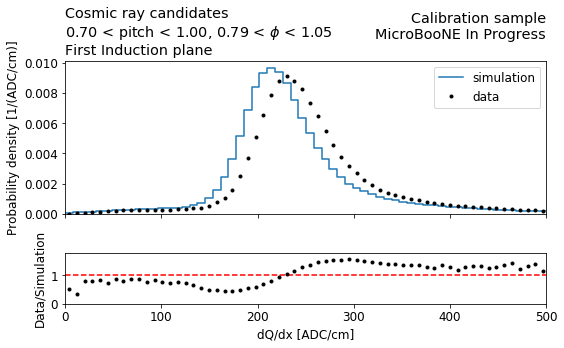

In [16]:
caloLike_calibration.plotLookUpDedxDataMC(plane_num=0,
                        pdg_code=13, 
                        data_selection='default',
                        parameters_value=[0.8, 0.9],
                        add_to_title='Calibration sample',
                        axis_label='dqdx')
plt.xlim(0, 500)
plt.tight_layout()
plt.savefig(save_folder+'plane_0_pitch_07_phi079.png', dpi=250)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:455: RuntimeWarning: divide by zero encountered in true_divide
  bin_contents_ratio = bin_contents_data / bin_contents_mc


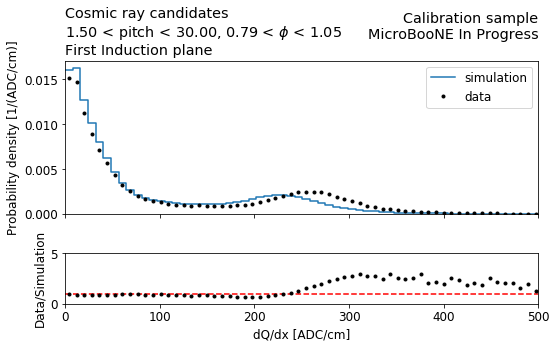

In [17]:
caloLike_calibration.plotLookUpDedxDataMC(plane_num=0,
                        pdg_code=13, 
                        data_selection='default',
                        parameters_value=[1.6, 0.9],
                        add_to_title='Calibration sample',
                        axis_label='dqdx')
plt.xlim(0, 500)
plt.tight_layout()
plt.savefig(save_folder+'plane_0_pitch_16_phi090.png', dpi=250)

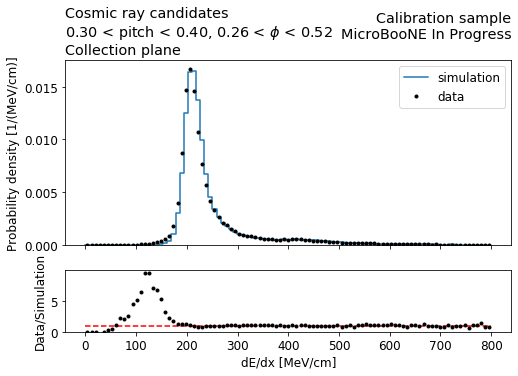

In [18]:
caloLike_calibration.plotLookUpDedxDataMC(plane_num=2,
                        pdg_code=13, 
                        data_selection='default',
                        parameters_value=[0.2, 0.4],
                        add_to_title='Calibration sample')

## Calibration only mu

In [19]:
def scale_calibration(mu, dedx):
    return dedx * mu[0]

In [20]:
caloLike_calibration.setCalibrationFunction(calibration_function=scale_calibration, 
                                n_calibration_parameters=1)

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:486: RuntimeWarning: divide by zero encountered in log
  total_expectations - dedx_data_binned*np.log(total_expectations),


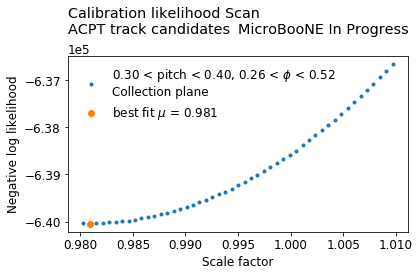

In [21]:
#example
caloLike_calibration.calibrationLikelihoodProfile(plane_num=2, 
                                                  parameters_value=[0.3, 0.4], 
                                                  pdg_code=13, 
                                                  start_point=[1],
                                                  data_selection='default', 
                                                  plot=True,
                                                  mu_binnings=[[0.98, 1.01, 50]])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
# plt.savefig(save_folder+'plane_2_pitch_0.75.png', dpi=250)

In [22]:
mu_scan_binning = [[0.9, 1.15, 50]]
for plane in [0, 1, 2]:
    caloLike_calibration.buildCalibrationTable(mu_scan_binning=mu_scan_binning, 
                          plane_num=plane, 
                          pdg_code=13, 
                          start_point=[1],
                          data_selection='default', 
                          plot_folder=save_folder_calibration+'plane{}/'.format(plane))
    edges, table = caloLike_calibration.plotCalibration2d(plane, annotated=True)
    plt.ylim(0.3, 1.5)
    plt.clim(0.85, 1.15) 
    plt.tight_layout()
    plt.savefig(save_folder_calibration+'calibration_table_plane_{}.png'.format(plane), dpi=200)
    plt.savefig(save_folder_calibration+'calibration_table_plane_{}.pdf'.format(plane))
    plt.close()

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method 

[5, 6] [array([ 0.35,  0.55,  0.85,  1.25, 15.75]), array([0.13089969, 0.39269908, 0.65449847, 0.91629786, 1.17809725,
       1.43989663])]


/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward

[5, 6] [array([ 0.35,  0.55,  0.85,  1.25, 15.75]), array([0.13089969, 0.39269908, 0.65449847, 0.91629786, 1.17809725,
       1.43989663])]


/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:486: RuntimeWarning: divide by zero encountered in log
  total_expectations - dedx_data_binned*np.log(total_expectations),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/l

[5, 6] [array([ 0.35,  0.55,  0.85,  1.25, 15.75]), array([0.13089969, 0.39269908, 0.65449847, 0.91629786, 1.17809725,
       1.43989663])]


/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


In [23]:
# for plane in [0, 1, 2]:
#     edges, table = caloLike_calibration.plotCalibration2d(plane, annotated=True)
#     plt.ylim(0.3, 1.5)
#     plt.clim(0.85, 1.15)
#     plt.tight_layout()
#     plt.savefig(save_folder+'calibration_table_plane_{}.png'.format(plane), dpi=200)
#     plt.close()

In [24]:
#print table
# caloLike_calibration.printCplusplusCorrection(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_correction_lookup.h', planes=[0, 1, 2])

In [25]:
#dump calibration object
# caloLike_calibration.save(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch.dat')

## Plot pdf before and after - train set

In [19]:
load_calibration = True

In [20]:
caloLike_calibration2 = caloLikelihood(array_mc_train, quality_mask=muon_train, quality_masks_planes=mc_train_planes)
caloLike_calibration2.setCalibrationFunction(calibration_function=scale_calibration, 
                                n_calibration_parameters=1)
if load_calibration:
    filename = '/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch.dat'
    caloLikelihood_load = caloLikelihood(None)
    caloLikelihood_load.load(filename)
    caloLike_calibration2.calibration_table = caloLikelihood_load.calibration_table
elif ~load_calibration:
    caloLike_calibration2.calibration_table = caloLike_calibration.calibration_table
else:
    print("you need to set load calibration")

In [21]:
caloLike_calibration2.setPdgCodeVar(pdgcode_var)
    
for i_pl, name_plane in zip([0, 1, 2], ['_u', '_v', '_y']):
    print(i_pl)
    this_parameters = [par+name_plane for par in parameters]
    caloLike_calibration2.setVariablesBinning(i_pl, this_parameters, parameters_bin_edges, dedx_vars+name_plane, dedx_bins, parameters_legend_names)
    caloLike_calibration2.buildLookUpTableMC(i_pl, 13, cali=True)

0
1
2


In [27]:
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_calibration.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        calibration_index = caloLike_calibration.findLookUpRow(plane_num, bin_center)
        for plot in ['data_mc', 'data_mc_cali']:
            fig, ax = plt.subplots(ncols=1,
                                       nrows=2,
                                       figsize=(6.5, 5),
                                       sharex='col',
                                       gridspec_kw={'height_ratios': [3, 1]})

            plt.sca(ax[0])
            if plot == 'data_mc':
                bin_contents_mc = caloLike_calibration.plotLookUpDedxMCfancy(plane_num=plane_num,
                                pdg_code=13, 
                                parameters_value=bin_center,
                                title_left='Cosmic ray candidates\n', 
                                label='mc', 
                                axis_label='dqdx')
                
            elif plot == 'data_mc_cali':
                bin_contents_mc = caloLike_calibration.plotLookUpDedxMC(plane_num=plane_num,
                                        pdg_code=13, 
                                        parameters_value=bin_center, 
                                        label='mc', 
                                        axis_label='dqdx')
                mu = caloLike_calibration2.calibration_table[plane_num][calibration_index]
                bin_contents_mc_cali = caloLike_calibration2.plotLookUpDedxMCfancy(plane_num=plane_num,
                                        pdg_code=13, 
                                        parameters_value=bin_center,
                                        title_left='Cosmic ray candidates\n', 
                                        label='mc corrected\n$\mu$ = {:.3g}'.format(mu[0]), 
                                        axis_label='dqdx')

            bin_contents_data = caloLike_calibration.plotLookUpDedxData(plane_num=plane_num,
                                    data_selection='default', 
                                    parameters_value=bin_center, 
                                    axis_label='dqdx')

            plt.title('MicroBooNE in Progress', loc='right')
            dedx_bins_centers = caloLike_calibration.dedx_bins_centers[plane_num]
            dedx_bins_edges = caloLike_calibration.dedx_bin_edges[plane_num]
            plt.legend()
            plt.xlabel('')
            plt.xlim(0, 500)
    #             import pdb; pdb.set_trace()
            plt.sca(ax[1])
            plt.plot(dedx_bins_centers, bin_contents_data/bin_contents_mc, '.', label='mc')
            if plot == 'data_mc_cali':
                plt.plot(dedx_bins_centers, bin_contents_data/bin_contents_mc_cali, '.', label=r'mc corrected')
            plt.plot([dedx_bins_edges[0], dedx_bins_edges[-1]], [1, 1], '--k', alpha=0.3)
            plt.ylim(0.5, 2)
            plt.xlabel('dQ/dx [ADC/cm]')
            plt.ylabel('Data/Simulation')
            plt.tight_layout()
            if plot == 'data_mc':
                this_save_folder = save_folder_data_mc
            elif plot == 'data_mc_cali':
                this_save_folder = save_folder_data_mc_cali
            plt.savefig(this_save_folder + 'plane{}/pitch_{:.2f}_phi_{:.2f}'.format(plane_num, bin_center[0], bin_center[1]).replace('.', '')+'.png', dpi=250)
            plt.savefig(this_save_folder + 'plane{}/pitch_{:.2f}_phi_{:.2f}'.format(plane_num, bin_center[0], bin_center[1]).replace('.', '')+'.pdf')
            plt.close()

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zer

# Plot integrated distribution dQ/dx, theta and phi

In [28]:
filename = '/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch.dat'
caloLikelihood_cali = caloLikelihood(None)
caloLikelihood_cali.load(filename)

for plane_num, plane in enumerate(['u', 'v', 'y']):
    caloLike_calibration.array['dqdx_{}_cali'.format(plane)] = caloLikelihood_cali.calibrateDedxExternal(caloLike_calibration.array, plane_num)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:177: RuntimeWarning: invalid value encountered in greater
  np.where((parameter_value>parameter_bin_edges[0]) & (parameter_value<parameter_bin_edges[-1]),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:177: RuntimeWarning: invalid value encountered in less
  np.where((parameter_value>parameter_bin_edges[0]) & (parameter_value<parameter_bin_edges[-1]),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:179: RuntimeWarning: invalid value encountered in less_equal
  np.where((parameter_value<=parameter_bin_edges[0]),


In [34]:
variables = [
#              'trk_theta',
#              'trk_phi',
#              'trk_len',
             'dqdx_u',
             'dqdx_v',
             'dqdx_y',
            ]

binnings = {
    'trk_theta': [0, np.pi, 31],
    'trk_phi': [-np.pi, 0, 31],
    'trk_len': [30, 300, 15],
    'dqdx_u': [0, 600, 100],
    'dqdx_v': [0, 600, 100],
    'dqdx_y': [0, 600, 100],
}

plane2num = {
    'u': 0,
    'v': 1,
    'y': 2,
}

plane2string = {
    'u': 'First Induction Plane',
    'v': 'Second Induction Plane',
    'y': 'Collection Plane',
}

xlabels = {
    'trk_theta': r'Track $\theta$',
    'trk_phi': r'Track $\phi$',
    'trk_len': r'Track length [cm]',
    'dqdx_u': r'Hit dQ/dx [ADC/cm]',
    'dqdx_v': r'Hit dQ/dx [ADC/cm]',
    'dqdx_y': r'Hit dQ/dx [ADC/cm]',
}

ylabels = {
    'trk_theta': r'Probability density',
    'trk_phi': r'Probability density',
    'trk_len': r'Probability density [1/cm]',
    'dqdx_u': r'Probability density [1/(ADC/cm)]',
    'dqdx_v': r'Probability density [1/(ADC/cm)]',
    'dqdx_y': r'Probability density [1/(ADC/cm)]',
}

for var in variables:    
    binning = binnings[var]
    mc_mask = muon_train
    if 'dqdx' in var:
        i = plane2num[var[-1]]
        mc_mask = mc_mask & mc_train_planes[i]
            
    for plot in ['data_mc', 'data_mc_cali']:
        fig, ax = plt.subplots(ncols=1,
                                       nrows=2,
                                       figsize=(6.5, 5),
                                       sharex='col',
                                       gridspec_kw={'height_ratios': [3, 1]})

        plt.sca(ax[0])
    
        if plot == 'data_mc':
            mc_entries = caloLike_calibration.array[var][mc_mask].flatten()
            bin_contents_mc, bin_edges = np.histogram(mc_entries, range=(binning[0], binning[1]), bins=binning[2], density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
            plt.plot(bin_edges, np.append(bin_contents_mc, bin_contents_mc[-1]), label='mc', ds='steps-post')
        elif plot == 'data_mc_cali':
            mc_entries = caloLike_calibration.array[var][mc_mask].flatten()
            bin_contents_mc, bin_edges = np.histogram(mc_entries, range=(binning[0], binning[1]), bins=binning[2], density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
            plt.plot(bin_edges, np.append(bin_contents_mc, bin_contents_mc[-1]), label='mc', ds='steps-post')
            
            mc_entries = caloLike_calibration.array[var+'_cali'][mc_mask].flatten()
            bin_contents_mc_cali, bin_edges = np.histogram(mc_entries, range=(binning[0], binning[1]), bins=binning[2], density=True)
            plt.plot(bin_edges, np.append(bin_contents_mc_cali, bin_contents_mc_cali[-1]), label='mc corrected', ds='steps-post')
        
        left_title = 'Cosmic ray candidates'
        if 'dqdx' in var:
            left_title += '\n'
            left_title += plane2string[var[-1]]
        plt.title(left_title, loc='left')

        data_mask = data_train
        if 'dqdx' in var:
            i = plane2num[var[-1]]
            data_mask = data_mask & data_train_planes[i]

        data_entries = caloLike_calibration.array_data[var][data_mask].flatten()
        bin_contents_data, bin_edges = np.histogram(data_entries, range=(binning[0], binning[1]), bins=binning[2], density=True)
        plt.plot(bin_centers, bin_contents_data, 'k.', label='data')

        plt.title('MicroBooNE in Progress', loc='right')
        plt.legend()
        plt.xlabel('')
        plt.ylabel(ylabels[var])
        plt.ylim(bottom=0)
        plt.xlim(binning[0], binning[1])

        plt.sca(ax[1])
        plt.plot(bin_centers, bin_contents_data/bin_contents_mc, '.', label='mc')
        if plot == 'data_mc_cali':
            plt.plot(bin_centers, bin_contents_data/bin_contents_mc_cali, '.', label=r'mc corrected')
        plt.plot([bin_edges[0], bin_edges[-1]], [1, 1], '--k', alpha=0.3)
        plt.ylim(0.5, 2)
        plt.xlabel(xlabels[var])
        plt.ylabel('Data/Simulation')
        plt.tight_layout()

        plt.savefig(save_folder + '{}_{}'.format(var, plot) + '.png', dpi=250)
        plt.savefig(save_folder + '{}_{}'.format(var, plot) + '.pdf')
        plt.close()

# Studies for pitch-phi distribution in every bin

In [29]:
arrays = {
    'mc': array_mc_train, 
#     'data': array_data_train,
}

scale_factors = {
    'mc': 1., 
#     'data': 1.,
}

my_plotter = plotter(arrays, scale_factors, pot_beam_on=1, branch_weights_name=None)

In [30]:
title_base = "track len > 20 cm, downward going"

for plane_num, plane in zip([0, 1, 2], ['_u', '_v', '_y']):
    for par0_edges in zip(parameters_bin_edges[0][:-1], parameters_bin_edges[0][1:]):
        for par1_edges in zip(parameters_bin_edges[1][:-1], parameters_bin_edges[1][1:]):
            this_parameters = [par+plane for par in parameters]
            def sel_function(array):
                return (array['first_last_hit_mask'+plane]) &\
                       selection_mask(array) &\
                       (np.abs(array['backtracked_pdg'])==13) &\
                        ((array[this_parameters[0]]) > par0_edges[0]) &\
                        ((array[this_parameters[0]]) <= par0_edges[1]) &\
                        ((array[this_parameters[1]]) > par1_edges[0]) &\
                        ((array[this_parameters[1]]) <= par1_edges[1])
            label = 'plane {}, {:.2g} < {} < {:.2g} & {:.2g} < {} < {:.2g}'.format(plane_num, par0_edges[0], 
                                                         parameters_legend_names[0],
                                                         par0_edges[1],
                                                         par1_edges[0], 
                                                         parameters_legend_names[1],
                                                         par1_edges[1],)
            save_label = 'sim_{:.2f}_{}_{:.2f}_{:.2f}_{}_{:.2f}'.format( 
                                                         par0_edges[0], 
                                                         parameters_legend_names[0],
                                                         par0_edges[1],
                                                         par1_edges[0], 
                                                         parameters_legend_names[1],
                                                         par1_edges[1]).replace('.', '').replace('$', '').replace('\\', '')
            title = title_base + '\n' + label
            out = my_plotter.plot2d(dataset_name='mc', 
                                    variables=this_parameters, 
                                    binning=[15, par0_edges[0], par0_edges[1], 15, par1_edges[0], par1_edges[1]], 
                                    additional_selection=sel_function, 
                                    title="Simulated ACPT\n" + title,
                                    labels=["Hit pitch", r"Hit $\phi$"], 
                                    density=True,
                                    log=True)
            plt.tight_layout()
            plt.savefig(save_folder_pitch_phi + 'plane{}/'.format(plane_num) + save_label+'.png', dpi=300)
            plt.savefig(save_folder_pitch_phi + 'plane{}/'.format(plane_num) + save_label+'.pdf')
            plt.close()

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value enco

## As a function of run number

In [31]:
plt.hist(caloLike_train.array_data['run'], bins=50, alpha=0.5, label='train')
plt.hist(caloLike_test.array_data['run'], bins=50, alpha=0.5, label='test')
plt.legend()
plt.xlabel("run number")
plt.title("MicroBooNE in Progress", loc='right')
plt.title("Run number used for ACPT candidates\nBeam OFF data", loc='left')

NameError: name 'caloLike_train' is not defined

In [ ]:
plt.hist(caloLike_train.array['run'], bins=50, alpha=0.5, label='train')
plt.hist(caloLike_test.array['run'], bins=50, alpha=0.5, label='test')
plt.legend()
plt.xlabel("run number")
plt.title("MicroBooNE in Progress", loc='right')
plt.title("Run number used for ACPT candidates\nSimulation w/ overlay", loc='left')

In [ ]:
ar = caloLike_train.array
final_label = "\nACPT w/ overlay data\nTrain set"

In [ ]:
run = ar['run']
dedx_y = ar['dedx_y']
theta_z = ar['abs_theta_z_y']
theta_yx = ar['abs_theta_yx_y']
x = ar['x_y']

dedx_mask = (theta_z > 0) & (theta_z < 0.52) & (theta_yx > 0.39) & (theta_yx < 0.59) & mc_train_planes[2]

xlabel = {
    "dedx": "dE/dx - Y plane [MeV/cm]",
    "theta": r"$\theta$",
    "phi": r"$\phi$",
    "x": "x [cm]",
}

binnings = {
    "dedx" : [0, 4, 101],
    "theta" : [0, np.pi/2, 101],
    "phi" : [0, np.pi/2, 101],
    "x" : [-10, 270, 101],
}

arrays_here = {
    "dedx" : dedx_y,
    "theta" : theta_z,
    "phi" : theta_yx,
    "x" : x,
}

for var in ['dedx', 'theta', 'phi', 'x']:
    run_binning = [7000, 7200, 7600, 7800]
    for run_bins in zip(run_binning[:-1], run_binning[1:]):
        run_mask = (run > run_bins[0]) & (run < run_bins[1])
        aux = arrays_here[var][dedx_mask & run_mask].flatten()
        plt.hist(aux, 
                 bins=binnings[var][2], 
                 range=[binnings[var][0], binnings[var][1]], 
                 histtype='step', 
                 density=True, 
                 label='{} < run < {}\n{} hits\n{} tracks'.format(run_bins[0], run_bins[1], len(aux), 
                                                                  arrays_here[var][dedx_mask & run_mask].any().sum()))
    plt.legend()
    plt.xlabel(xlabel[var])
    plt.title("MicroBooNE in Progress", loc='right')
    plt.title("ACPT candidates\n" +
              r"{} < $\theta$ < {} & {} < $\phi$ < {}".format(0, 0.52, 0.39, 0.59) +
              final_label, loc='left')
    plt.tight_layout()
    plt.savefig(save_folder+var+"_bin_run.png", dpi=500)
    plt.close()

# Studies for pitch dependence for small pitch

In [ ]:
dedx_binning = [100, 500]
dedx_n_bins = 150
pitch_binning = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

sel_mc = muon_train & mc_train_planes[2] & (array_mc_train['dqdx_y']>100) & (array_mc_train['dqdx_y']<400)
sel_data = data_train_mask & data_train_planes[2] & (array_data_train['dqdx_y']>100) & (array_data_train['dqdx_y']<400)

for array, sel, name in zip([array_mc_train, array_data_train], [sel_mc, sel_data], ['simulation', 'data']):
    for pitch_bin in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch_y'] > pitch_bin[0]) & (array['pitch_y'] <= pitch_bin[1])
        
        dedx = array['dqdx_y'][pitch_mask & sel].flatten()
        
        sns.distplot(dedx, hist=False, kde=True,
                 kde_kws={'linewidth': 1},
                 label='{:.2g} < pitch < {:.2g}'.format(pitch_bin[0], pitch_bin[1]), norm_hist=True)
        
#         plt.hist(dedx, bins=dedx_n_bins, range=dedx_binning, density=True,
#                  label='{:.2g} < pitch < {:.2g}'.format(pitch_bin[0], pitch_bin[1]), histtype='step')
    
    plt.title('ACPT candidates in {}\n'.format(name)+
              'collection plane hits\n', loc='left')
    plt.title('MicroBooNE In Progress', loc='right')
#     plt.xlim(0, 4)  
    plt.xlabel('dQ/dx [ADC/cm]')
    plt.ylabel('Probability density [1/(ADC/cm)]')
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_folder+'dedx_different_pitch_{}.png'.format(name), dpi=250)
    plt.close()

### Dump, load and closure test calibration

In [ ]:
#load calibration table
# caloLike_table = caloLikelihood(None)
# caloLike_table.load(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch.dat')
# caloLike_calibration.calibration_table = caloLike_table.calibration_table

In [ ]:
#1
caloLike_dump_test1 = caloLikelihood(array_mc_test, quality_mask=muon_test, quality_masks_planes=mc_test_planes)
caloLike_dump_test1.setPdgCodeVar(pdgcode_var)
i=1
caloLike_dump_test1.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], np.linspace(0, 10000, 100), parameters_legend_names[i])
caloLike_dump_test1.setCalibrationFunction(calibration_function=scale_calibration, n_calibration_parameters=1)
caloLike_dump_test1.calibration_table = caloLike_calibration.calibration_table
caloLike_dump_test1.buildLookUpTableMC(i, 13, cali=True)

In [ ]:
#2
caloLikelihood_cali_trail = caloLikelihood(None)
caloLikelihood_cali_trail.load(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration.dat')
array_mc_test['dedx_v_cali'] = caloLikelihood_cali_trail.calibrateDedxExternal(array_mc_test, 1)
caloLike_dump_test2 = caloLikelihood(array_mc_test, quality_mask=muon_test, quality_masks_planes=mc_test_planes)
caloLike_dump_test2.setPdgCodeVar(pdgcode_var)
i=1
caloLike_dump_test2.setVariablesBinning(i, parameters[i], parameters_bin_edges, 'dedx_v_cali', np.linspace(0, 10000, 100), parameters_legend_names[i])
caloLike_dump_test2.buildLookUpTableMC(i, 13, cali=False)

In [ ]:
(caloLike_dump_test1.lookup_tables[13][1] - caloLike_dump_test2.lookup_tables[13][1]).any()